In [46]:
#pip install yfinance

In [47]:
import yfinance as yf
import pandas as pd
import json 
import matplotlib.pyplot as plt
import matplotlib
import re
import string
string.punctuation
from nltk.corpus import stopwords
import regex
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import datetime
import seaborn as sns

In [48]:
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Question 1


In [49]:
df0 = pd.read_json(r'/content/drive/MyDrive/ACE592/Trump_tweets.json')
df0.head(2)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status,extended_entities,withheld_scope,withheld_copyright,withheld_in_countries
0,2020-11-05 15:37:40+00:00,1324375334653988864,1324375334653988864,Fmr NV AG Laxalt: ‘No Question‘ Trump Would Ha...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 25073877, 'id_str': '25073877', 'name':...",NaN,NaN,NaN,NaN,False,27745,124472,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-11-05 15:09:19+00:00,1324368202139357186,1324368202139357184,ANY VOTE THAT CAME IN AFTER ELECTION DAY WILL ...,False,"[0, 61]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 25073877, 'id_str': '25073877', 'name':...",NaN,NaN,NaN,NaN,False,0,0,False,False,NaN,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
#formatting dataframe
df = df0.loc[:,('full_text','entities','retweet_count','favorite_count')]
df['Censored'] = df['retweet_count'] == 0
df['Timestamp'] = df0['created_at']
df['Timestamp'] = df.Timestamp.astype('M8[ns]',).astype('O')
df['Date'] = df.Timestamp.apply(lambda x: x.strftime('%Y/%m/%d'))
df['Date']= pd.to_datetime(df['Date']).dt.date
df['Timestamp'] = pd.to_datetime(df['Timestamp'],format='%I%M%S')
df['full_text'] = df['full_text'].astype(str)
df.dtypes

full_text                 object
entities                  object
retweet_count              int64
favorite_count             int64
Censored                    bool
Timestamp         datetime64[ns]
Date                      object
dtype: object

In [51]:
#Split words
text = [x.split(' ') for x in df.full_text]

#loop and remove links, mentions and #
prefixes = ('https', '#', '@','\n','\r')
remv_punc = str.maketrans('','',string.punctuation + '“' +"‘"+'”' + "'")
separator = ' '
replaces = ['‘',"\n","\r","’",'"','¡']

for n in range(len(text)):
  text[n] = [x for x in text[n] if not x.startswith(prefixes)]
  text[n] = separator.join(text[n]).lower()
  for i in replaces:
    text[n] = text[n].replace(i," ")
  text[n] = text[n].translate(remv_punc)
  text[n] = text[n].split(' ')
  text[n] = separator.join(text[n]).lower()

df['clean_text'] = text

#Take blank spaces out
df = df[df['clean_text'] != '']

#Drop duplicates
df = pd.DataFrame(df.drop_duplicates('clean_text'))
df

,full_text,entities,retweet_count,favorite_count,Censored,Timestamp,Date,clean_text
0,Fmr NV AG Laxalt: ‘No Question‘ Trump Would Ha...,"{'hashtags': [], 'symbols': [], 'user_mentions...",27745,124472,False,2020-11-05 15:37:40,2020-11-05,fmr nv ag laxalt no question trump would hav...
1,ANY VOTE THAT CAME IN AFTER ELECTION DAY WILL ...,"{'hashtags': [], 'symbols': [], 'user_mentions...",0,0,True,2020-11-05 15:09:19,2020-11-05,any vote that came in after election day will ...
2,STOP THE COUNT!,"{'hashtags': [], 'symbols': [], 'user_mentions...",120833,750449,False,2020-11-05 14:12:37,2020-11-05,stop the count
3,"Detroit Absentee Ballot Counting Chaos, Blocke...","{'hashtags': [], 'symbols': [], 'user_mentions...",71580,249948,False,2020-11-05 00:01:07,2020-11-05,detroit absentee ballot counting chaos blocked...
4,Demands Arise for PA Attorney General to ‘Step...,"{'hashtags': [], 'symbols': [], 'user_mentions...",44496,172668,False,2020-11-05 00:00:05,2020-11-05,demands arise for pa attorney general to step...
...,...,...,...,...,...,...,...,...
1784,GREAT PATRIOTS! https://t.co/BWGxVoBTmI,"{'hashtags': [], 'symbols': [], 'user_mentions...",28849,139909,False,2020-08-30 10:37:39,2020-08-30,great patriots
1785,Disgraceful Anarchists. We are watching them c...,"{'hashtags': [], 'symbols': [], 'user_mentions...",20520,68859,False,2020-08-30 10:36:14,2020-08-30,disgraceful anarchists we are watching them cl...
1786,Democrat “Leadership” has no clue. Request hel...,"{'hashtags': [], 'symbols': [], 'user_mentions...",10607,33582,False,2020-08-30 10:31:53,2020-08-30,democrat leadership has no clue request help n...
1787,ANTIFA is a Radical Left group that only wants...,"{'hashtags': [], 'symbols': [{'text': 'FOOLS',...",22742,65156,False,2020-08-30 10:28:46,2020-08-30,antifa is a radical left group that only wants...


Checking if it is properly cleaned

In [52]:
df.clean_text[0]

'fmr nv ag laxalt  no question  trump would have won nevada  convincingly  without mailin voting via'

In [53]:
df.full_text[0]

'Fmr NV AG Laxalt: ‘No Question‘ Trump Would Have Won Nevada ‘Convincingly‘ Without Mail-in Voting https://t.co/pm4Wpfr6x0 via @BreitbartNews'

In [54]:
df.sort_values('clean_text')

,full_text,entities,retweet_count,favorite_count,Censored,Timestamp,Date,clean_text
54,¡Mi #AmericanDreamPlan es una promesa para los...,"{'hashtags': [{'text': 'AmericanDreamPlan', 'i...",18847,93730,False,2020-11-02 22:24:45,2020-11-02,mi es una promesa para los hispanoamericanos ...
591,@maggieNYT There has never been a time in eit...,"{'hashtags': [], 'symbols': [], 'user_mentions...",12615,51000,False,2020-10-19 17:27:21,2020-10-19,there has never been a time in either of my t...
1180,‘Trump Was Right’: Explosive New FBI Texts Det...,"{'hashtags': [], 'symbols': [], 'user_mentions...",37331,79555,False,2020-09-24 20:55:36,2020-09-24,trump was right explosive new fbi texts deta...
1471,"""What are the odds of 31 phones accidentally w...","{'hashtags': [], 'symbols': [], 'user_mentions...",18605,48385,False,2020-09-12 01:33:49,2020-09-12,what are the odds of 31 phones accidentally w...
639,100% True! https://t.co/QWvpzSopkl,"{'hashtags': [], 'symbols': [], 'user_mentions...",19910,66814,False,2020-10-17 19:18:35,2020-10-17,100 true
...,...,...,...,...,...,...,...,...
226,"Your far-left Dem Attorney General, and your D...","{'hashtags': [], 'symbols': [], 'user_mentions...",30174,115189,False,2020-10-31 00:04:19,2020-10-31,your farleft dem attorney general and your dem...
1519,Your mother is GREAT! https://t.co/1TeKxnvuLw,"{'hashtags': [], 'symbols': [], 'user_mentions...",6495,32073,False,2020-09-10 12:33:44,2020-09-10,your mother is great
291,"Your VOTE on Tuesday, November 3rd is going to...","{'hashtags': [{'text': 'MAGA', 'indices': [181...",14287,58100,False,2020-10-29 19:54:59,2020-10-29,your vote on tuesday november 3rd is going to ...
239,Your VOTE will continue HISTORIC job growth an...,"{'hashtags': [], 'symbols': [], 'user_mentions...",8490,38821,False,2020-10-30 19:16:09,2020-10-30,your vote will continue historic job growth an...


# Question 2

Sliptting and setting up

In [55]:
#Split text in words
words = [x.split(" ") for x in df['clean_text']]
words_list = [pd.Series(x).value_counts() for x in words]
word_df = pd.concat(words_list,axis=1).fillna(0).T

# removing stopwords:
#Get stopwords to delete
sw_list = stopwords.words('english') + [" ", '']

words_nsw = word_df.loc[:,~word_df.T.index.isin(sw_list)]

Actually counting words:


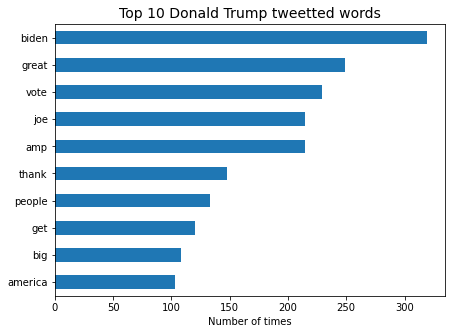

In [56]:
'''Top 10 words'''
top10 = words_nsw.sum().sort_values(ascending=False).head(10)
top10.sort_values().tail(10).plot(kind='barh',figsize=(7,5));
plt.xlabel("Number of times");
plt.title("Top 10 Donald Trump tweetted words",fontsize=14);

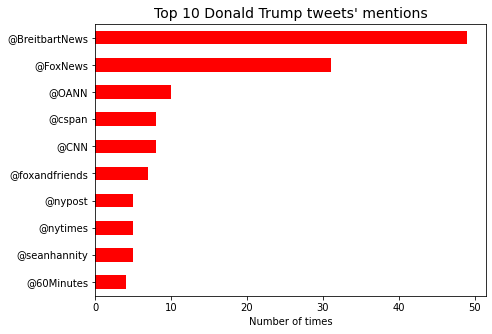

In [57]:
'''Top 5 mention'''
top5ment = df.full_text.str.findall(r'(@\w+)').explode().value_counts()
top5ment.sort_values(ascending=True).tail(10).plot(kind='barh',figsize=(7,5), color='red');
plt.xlabel("Number of times");
plt.title("Top 10 Donald Trump tweets' mentions",fontsize=14);

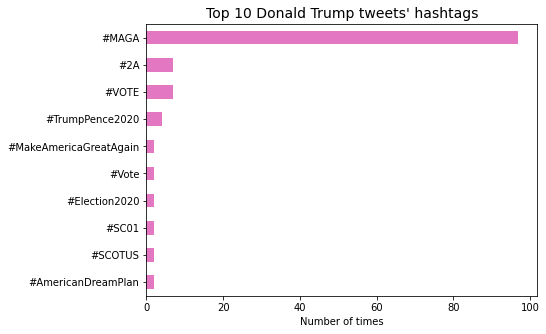

In [58]:
'''Top 5 hashtags'''
top5hash = df.full_text.str.findall(r'(#\w+)').explode().value_counts()
top5hash.sort_values(ascending=True).tail(10).plot(kind='barh',figsize=(7,5), color='C26');
plt.xlabel("Number of times");
plt.title("Top 10 Donald Trump tweets' hashtags",fontsize=14);

In [59]:
'''Top 5 favorites tweets'''
top5t = df.sort_values('favorite_count', ascending=False).head(5)
top5t[['favorite_count','full_text']]

,favorite_count,full_text
1014,1858018,"Tonight, @FLOTUS and I tested positive for COV..."
1012,1202110,"Going welI, I think! Thank you to all. LOVE!!!"
17,957283,WE ARE LOOKING REALLY GOOD ALL OVER THE COUNTR...
16,925883,I will be making a statement tonight. A big WIN!
24,905506,This Tweet from @realDonaldTrump has been with...


# Question 3

Text(0.5, 1.0, 'Volume of Donald Trump tweets with major events')

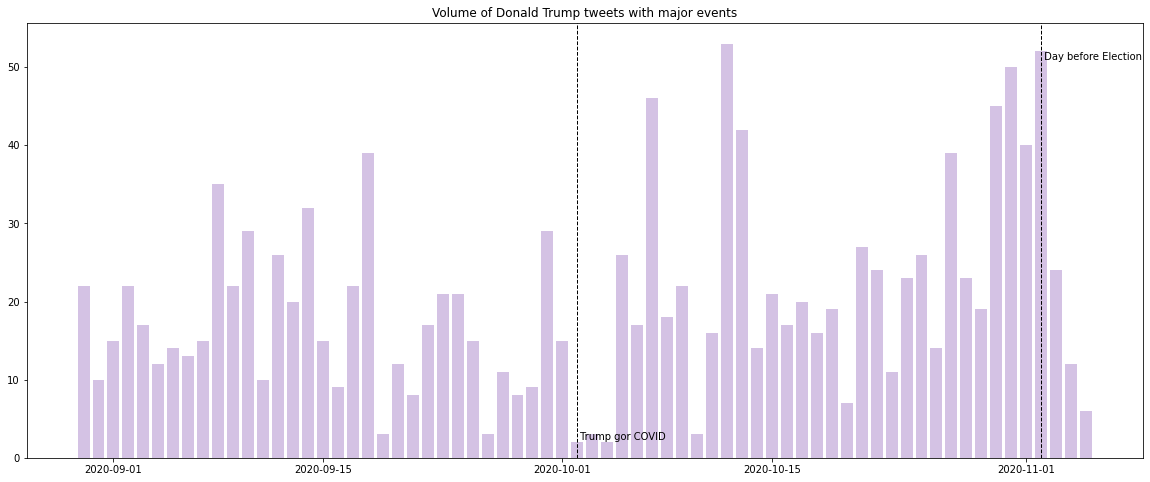

In [60]:
vol = df.groupby('Date').count().Censored
fig,ax = plt.subplots(figsize=(20,8))
ax.bar(vol.index,vol,alpha=0.4,color="C4")
ax.axvline(vol.index[64],color='black',ls='--',linewidth=1) #election
ax.axvline(vol.index[33],color='black',ls='--', linewidth=1) #Trump got corona
ax.annotate(s=(' Trump gor COVID'),xy=(vol.index[33],vol[33]),va="bottom")
ax.annotate(s=(' Day before Election'),xy=(vol.index[64],vol[64]),va='top')
ax.set_title('Volume of Donald Trump tweets with major events')
# df

Sentiment Analysis

# Question 4

In [61]:
#Top 20 positive and negative words
sid = SentimentIntensityAnalyzer()

s = words_nsw.sum().sort_values(ascending=False).reset_index()
s['sentiment_score'] = [sid.polarity_scores(x)['compound'] for x in s['index']]

top20words = s.sort_values('sentiment_score', ascending=False).head(20)
bottom20words = s.sort_values('sentiment_score', ascending=False).tail(20)

In [62]:
top20words

,index,0,sentiment_score
3325,magnificently,1.0,0.6597
200,love,17.0,0.6369
156,best,23.0,0.6369
1392,glorious,2.0,0.6369
254,greatest,14.0,0.6369
502,freedom,8.0,0.6369
1885,awesome,2.0,0.6249
1,great,249.0,0.6249
1244,outstanding,3.0,0.6124
3658,magnificent,1.0,0.5994


In [63]:
bottom20words

,index,0,sentiment_score
2770,racism,1.0,-0.6249
445,violence,8.0,-0.6249
191,disaster,18.0,-0.6249
1668,hatred,2.0,-0.6369
1157,betray,3.0,-0.6369
2390,murdering,1.0,-0.6486
1324,devastating,3.0,-0.6486
1898,killer,2.0,-0.6486
1034,dead,4.0,-0.6486
2120,villains,1.0,-0.6597


In [64]:
#Sentiment Analysis
sid = SentimentIntensityAnalyzer()
df['sentiment_score'] = [sid.polarity_scores(x)['compound'] for x in df['clean_text']]

Text(0.5, 1.0, "Donald Trump Tweets' Sentiment over time")

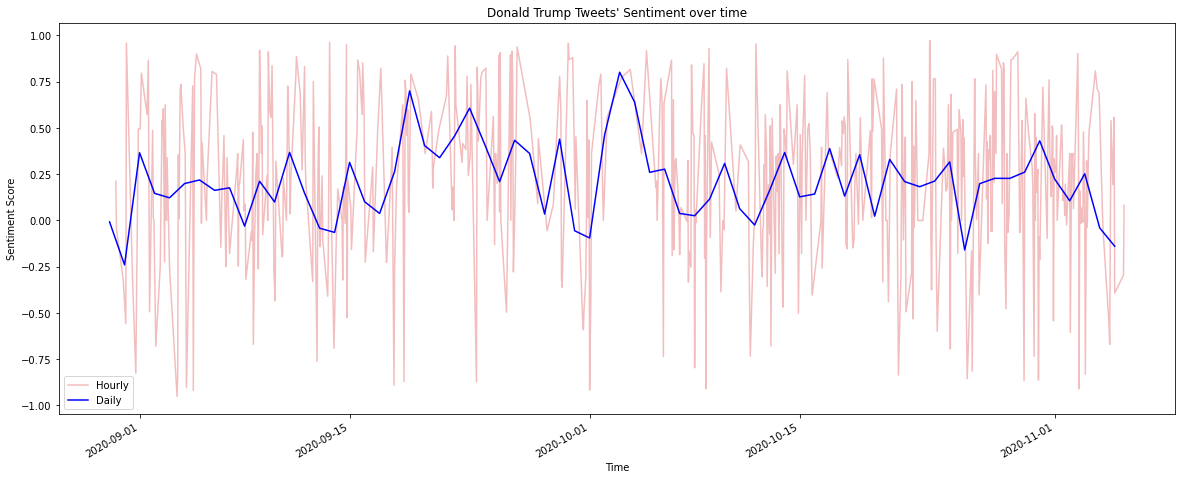

In [65]:
#sentment analysis by hour or minute
df['minute_ct'] = pd.to_datetime(df['Timestamp'].map(lambda x: str(x)[:-2]) +"00")
df['hour_ct'] = pd.to_datetime(df['Timestamp'].map(lambda x: str(x)[:-6]) +":00:00")
df['day_ct'] = pd.to_datetime(df['Timestamp'].map(lambda x: str(x)[:-8]) +"00:00:00")

f, a = plt.subplots(figsize=(20,8))
# df.groupby("minute_ct").sentiment_score.mean().plot(alpha=.3,label="Minute")
df.groupby("hour_ct").sentiment_score.mean().plot(alpha=.3,color="C3",label="Hourly")
df.groupby("day_ct").sentiment_score.mean().plot(color="Blue",label="Daily")
plt.legend(loc="lower left")
plt.xlabel("Time")
plt.ylabel("Sentiment Score")
plt.title("Donald Trump Tweets' Sentiment over time")

# Question 5


Trump and the stock market

In [66]:
#Getting the hourly date and sentiment scores
df['Timestamp2'] = pd.to_datetime(df['Timestamp'].map(lambda x: str(x)[:-6]) +":00:00")
sent2 = df.groupby('Timestamp2').sentiment_score.mean()

#downloading the SP500 data hourly
sp500 = yf.download('^GSPC',start =df.hour_ct.min(), end=df.hour_ct.max(), interval='60m')
sp500 = sp500.reset_index()
sp500['Time'] = pd.to_datetime(sp500['Datetime'].map(lambda x: str(x)[:-11]) +"00:00")

#merging using the trading days as base
data = sp500.merge(sent2, left_on='Time', right_on='Timestamp2', how='left')
data = data.loc[:,('Time','Adj Close','sentiment_score')]
data['Time'] = pd.to_datetime(data.Time)
data.set_index('Time', inplace=True)

[*********************100%***********************]  1 of 1 completed


For most of the time, when Trump twitted something good (with a good sentiment analysis) it was positively correlated with a SP500index increase.
As we look at the lagged returns, it seems to increase a bit (especially after 10h), but, in general, is a weak correlation.


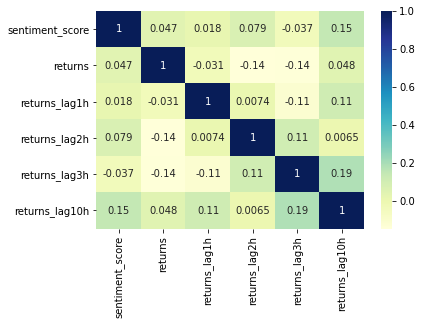

In [67]:
#getting returns and correlation
data['returns'] = data['Adj Close'].pct_change(axis=0)
data['returns_lag1h'] = data['returns'].shift(-1)
data['returns_lag2h'] = data['returns'].shift(-2)
data['returns_lag3h'] = data['returns'].shift(-3)
data['returns_lag10h'] = data['returns'].shift(-10)
returns = data.drop(columns='Adj Close').dropna()
cor = returns.corr()
#plot Correlation between assets
# sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(cor, cmap="YlGnBu",annot=True);
print('For most of the time, when Trump twitted something good (with a good sentiment analysis) it was positively correlated with a SP500index increase.'+ '\n'
      'As we look at the lagged returns, it seems to increase a bit (especially after 10h), but, in general, is a weak correlation.' )

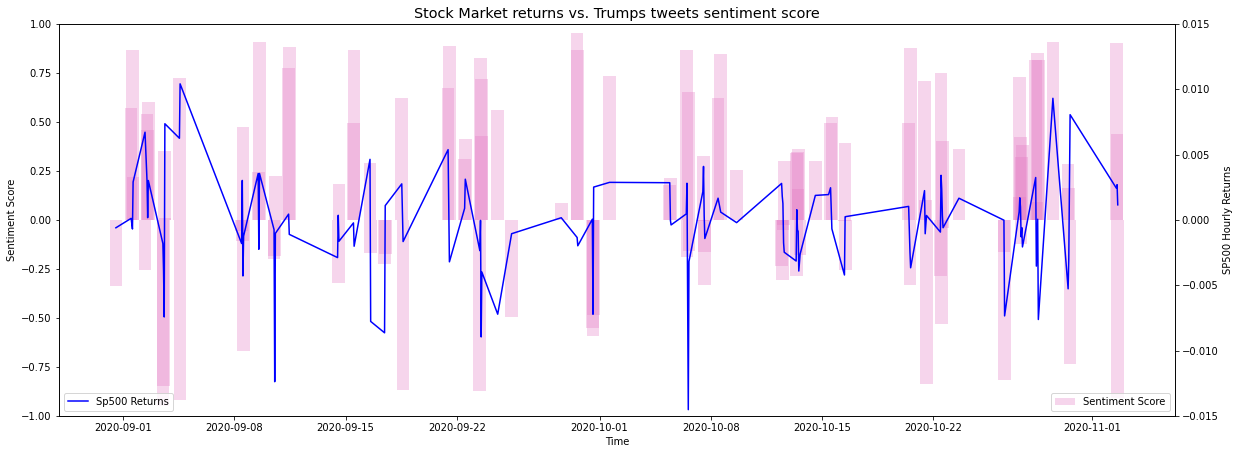

In [68]:
#plot
acc_ret = data['Adj Close'].pct_change(axis=0)
acc_ret.iloc[0] = 1
data['acc_ret'] = acc_ret.cumsum(axis=0)
data

f, a = plt.subplots(figsize=(20,8))
a.set_title('Stock Market returns vs. Trumps tweets sentiment score', fontsize='x-large')
a.bar(data.dropna().index,data.dropna()['sentiment_score'], color='C6', alpha=0.3)
a.set_ylim(-1,1)
a.set_ylabel('Sentiment Score')
a2=a.twinx()
a2 = data.dropna()['returns'].plot(color="Blue",label="SP500 Returns")
# a.legend(['Adj Close'])
# a2.legend(['Sentiment Score'])
a.legend(['Sentiment Score'], loc='lower right')
a2.legend(['Sp500 Returns'], loc='lower left')
a2.set_ylabel('SP500 Hourly Returns')
a2.set_ylim(-0.015,0.015)
a.set_xlabel('Time')

plt.show()

###Describe in detail how you would answer the question: "Did President Trump's tweet sentiment influence the stock market?" Specifically describe:

a. I would use hourly data from the SP500, NASDAQ and  Dow indexes. Would calculate the hourly returns (pct changes) and also the sentiment scores of Trumps tweets.

b. Pretty much like we did here. But I would add other indexes too.

c. Would lag the returns (with multiple lags) of the indexes and do a scatter plot with the sentment scores of Trump. Run a linear regression controlling for autocorrelation (previous returns) and see the coeficient and significance. 